In [1]:
from sunpy.map import Map
from sunpy.physics.differential_rotation import differential_rotate
from astropy.table import Table
from astropy.time import Time as aTime
from scipy import ndimage
import sunpy.timeseries as ts
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import astropy.units as u
import datetime
import glob

In [2]:
# Read fits files and make maps
tflare = "2013-11-08T04:26"
imask = 10
path = '/Volumes/Pandora/Willinton/20131108T0426/'
file_list = []
file_list.append(glob.glob(path+'*.i*.fits'))
file_list=sorted(file_list)
Mfiles=Map(file_list)

In [3]:
drMfiles = []
for mf in Mfiles: # Diff Rot correction for all maps
    mf.meta['CRDER1'] = 0.0 # changing 'CRDER1' and 'CRDER2' 
    mf.meta['CRDER2'] = 0.0 # keywords to avoid annoying warnings
    drMfiles.append(differential_rotate(mf,time=tflare)) # diff-rot to the flarepeak time 

/Users/Kamilobu/opt/anaconda3/lib/python3.7/site-packages/sunpy/physics/differential_rotation.py:153: UserWarning: Using 'time' assumes an Earth-based observer.
  warnings.warn("Using 'time' assumes an Earth-based observer.")
/Users/Kamilobu/opt/anaconda3/lib/python3.7/site-packages/sunpy/physics/differential_rotation.py:153: UserWarning: Using 'time' assumes an Earth-based observer.
  warnings.warn("Using 'time' assumes an Earth-based observer.")
/Users/Kamilobu/opt/anaconda3/lib/python3.7/site-packages/sunpy/physics/differential_rotation.py:153: UserWarning: Using 'time' assumes an Earth-based observer.
  warnings.warn("Using 'time' assumes an Earth-based observer.")
/Users/Kamilobu/opt/anaconda3/lib/python3.7/site-packages/sunpy/physics/differential_rotation.py:153: UserWarning: Using 'time' assumes an Earth-based observer.
  warnings.warn("Using 'time' assumes an Earth-based observer.")
/Users/Kamilobu/opt/anaconda3/lib/python3.7/site-packages/sunpy/physics/differential_rotation.py

In [28]:
# Máscara:
diff = drMfiles[imask+1].data-drMfiles[imask].data
Mdiff = Map(np.nan_to_num(np.abs(diff)),drMfiles[imask].meta)
Mdiffrot = Mdiff.rotate(angle=Mdiff.meta['crota2'] * u.deg)
mask = Mdiffrot.data > 10
Gdiff = ndimage.gaussian_filter(Mdiffrot.data,50)
Gmask = Gdiff > Gdiff.max()*0.72
labels, n = ndimage.label(Gdiff*Gmask)
flaremask = (labels==3)

In [37]:
# Creating arrays containing time-serie data
Int_Inc = []
tiempos = []
for mf in Mfiles:
    mfnn = Map(np.nan_to_num(mf.data-90),mf.meta)
    mfrot = mfnn.rotate(angle=mfnn.meta['crota2'] * u.deg)
    Int_Inc.append((mfrot.data*flaremask).sum())
    tiempos.append(datetime.datetime.strptime(mf.meta["date-obs"],'%Y-%m-%dT%H:%M:%S.%f'))

tbl_meta = {'t_key':'t_value'}
table = Table([tiempos, Int_Inc/np.max(Int_Inc)], names=['time', 'Inclination'], meta=Mfiles[imask].meta)
table.add_index('time')
ts_table = ts.TimeSeries(table)

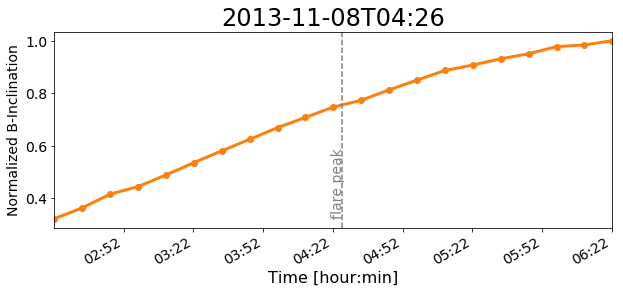

In [38]:
fig, ax = plt.subplots(figsize=(10,4))
ts_table.plot(marker='o',linewidth=3, color='tab:orange')
ax.axvline(tflare, color="gray", linestyle="--")
ax.text(tflare, np.min(Int_Inc/np.max(Int_Inc)), 'flare peak', fontsize=14,color='gray',rotation=90, rotation_mode='anchor')
ax.tick_params(axis='both',labelsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Time [hour:min]',fontsize=16)
ax.set_ylabel('Normalized B-Inclination',fontsize=14)
ax.set_title(tflare,fontsize=24)
plt.legend('',frameon=False) # fix bug with legend
fig.savefig('20131108T0422.pdf',dpi=150,bbox_inches='tight')
plt.show()

In [41]:
# Creating arrays containing time-serie data
Int_Inc = []
tiempos = []
for i in range(20):
    diff = Mfiles[i+1].data-Mfiles[i].data
    #Mdiff = Map(np.nan_to_num(np.abs(diff)),Mfiles[i].meta)
    Mdiff = Map(np.nan_to_num(np.abs(diff)),Mfiles[i].meta)
    Mdiffrot = Mdiff.rotate(angle=Mdiff.meta['crota2'] * u.deg)
    Int_Inc.append((Mdiffrot.data*flaremask).sum())
    tiempos.append(datetime.datetime.strptime(Mdiffrot.meta["date-obs"],'%Y-%m-%dT%H:%M:%S.%f'))

tbl_meta = {'t_key':'t_value'}
table = Table([tiempos, Int_Inc/np.max(Int_Inc)], names=['time', 'Inclination'], meta=Mfiles[i].meta)
table.add_index('time')
ts_table = ts.TimeSeries(table)

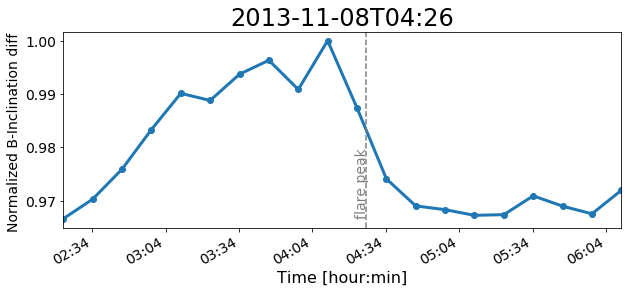

In [42]:
tflare = "2013-11-08T04:26"
fig, ax = plt.subplots(figsize=(10,4))
ts_table.plot(marker='o',linewidth=3)
ax.axvline(tflare, color="gray", linestyle="--")
ax.text(tflare, np.min(Int_Inc/np.max(Int_Inc)), 'flare peak', fontsize=14,color='gray',rotation=90, rotation_mode='anchor')
ax.tick_params(axis='both',labelsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Time [hour:min]',fontsize=16)
ax.set_ylabel('Normalized B-Inclination diff ',fontsize=14)
ax.set_title(tflare,fontsize=24)
plt.legend('',frameon=False) # fix bug with legend
fig.savefig('absdiff20131108T0422.pdf',dpi=150,bbox_inches='tight')
plt.show()